In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [9]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [10]:
class PI_DeepONet():
    def __init__(self, X, y, branch_layer, trunk_layer, lr, activation):
        self.U   = X[:, :-2]
        self.x   = X[:, -2:-1]
        self.t   = X[:, -1:]
        self.Guy_true = y
        self.activation = activation
        self.loss_log = []


        self.branch_layer = branch_layer
        self.trunk_layer  = trunk_layer

        self.sess = tf.Session()
        self.branch_weights, self.branch_biases = self.initilize_NN(branch_layer)
        self.trunk_weights, self.trunk_biases = self.initilize_NN(trunk_layer)
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32), dtype=tf.float32)

        self.U_tf   = tf.placeholder(tf.float32, shape=[None, self.U.shape[1]])
        self.x_tf   = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf   = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.Guy_tf = tf.placeholder(tf.float32, shape=[None, self.Guy_true.shape[1]])
        self.y_tf   = tf.concat([self.x_tf, self.t_tf], 1)

        self.branch_out = self.neural_net(self.U_tf, self.branch_weights, self.branch_biases, self.activation)
        self.trunk_out  = self.neural_net(self.y_tf, self.trunk_weights, self.trunk_biases, self.activation)
        self.Guy_pred = tf.reshape(tf.reduce_sum(tf.multiply(self.branch_out, self.trunk_out),
                                                 axis=1) + self.bias, [-1, 1])

        self.loss_operator = tf.reduce_mean(tf.square(self.Guy_pred - self.Guy_tf))
        #self.loss_operator = tf.sqrt(tf.reduce_sum(tf.square(self.Guy_pred - self.Guy_tf)))

        self.f = self.physics_net(self.x_tf, self.t_tf)
        self.loss_physics  = tf.reduce_mean(tf.square(self.f))

        self.loss = self.loss_operator + self.loss_physics

        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss,
                                                            global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def callback(self, loss):
        print('Loss:', loss)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def get_batch(self, batch_size):
        index = np.random.randint(0, self.U.shape[0], batch_size)
        return self.U[index, :], self.x[index, :], self.t[index, :], self.Guy_true[index, :]

    def train(self, max_iter=40000, batch_size=50):
        loss_value = np.inf
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            U, x, t, Guy_true = self.get_batch(batch_size)
            tf_dict = {
                self.U_tf : U,
                self.x_tf : x,
                self.t_tf : t,
                self.Guy_tf : Guy_true
            }
            _, loss_value, lp, lo = self.sess.run([self.optimizer, self.loss, self.loss_physics, self.loss_operator], tf_dict)
            self.loss_log.append(loss_value)
            self.sess.run(self.lr)
            if iter % 100 == 0:
                print("第%d次 %f,phy %f,ope %f"%(iter, loss_value, lp, lo))
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def predict(self, X_test):
        Guy_test = self.sess.run(self.Guy_pred, {self.U_tf: X_test[:, :-2], self.x_tf:X_test[:, -2:-1], self.t_tf:X_test[:, -1:]})
        return Guy_test

    def physics_net(self, x, t):
        u    = self.Guy_pred
        u_t  = tf.gradients(u, t)[0]
        u_x  = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f    = u_t + u * u_x - (0.01 / np.pi) * u_xx
        return f


In [11]:
import scipy.io
data = scipy.io.loadmat('./dataset/Burgers/burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
Exact =np.real(data['usol']).T

In [12]:
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]
# 初始点
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
# x=-1的边界点
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
# x=1的边界点
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
xbc = np.vstack((xx1, xx2, xx3))
ubc = np.vstack((uu1, uu2, uu3))

In [13]:
# t = 0.25
xx25 = np.hstack((X[25:26, :].T, T[25:26, :].T))
uu25 = Exact[25:26, :].T
# t = 0.50
xx50 = np.hstack((X[50:51, :].T, T[50:51, :].T))
uu50 = Exact[50:51, :].T
# t = 0.75
xx75 = np.hstack((X[75:76, :].T, T[75:76, :].T))
uu75 = Exact[75:76, :].T

In [14]:
sensors  = 256
y_d      = 2
random_y = xx1.shape[0]
p        = 10
branch_layers = [sensors, 100, 100, 100, 100, 100, 100, p]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, p]

In [15]:
idu = np.random.choice(xbc.shape[0], sensors, replace=False)
xbci = xbc[idu]
ubci = ubc[idu]

In [16]:
Exact_list = [uu25, uu50, uu75]
X_list = [xx25, xx50, xx75]
Guy_ = []
input_y = []
for i in range(len(Exact_list)):
    idx = np.random.choice(X_list[i].shape[0], random_y, replace=False)
    y = X_list[i][idx]
    input_y.append(y)
    Guy_.append(Exact_list[i][idx])
y_train = np.array(Guy_).reshape(-1, 1)

In [17]:
input_u = []
for i in range(len(X_list)):
    input_u.append(np.hstack([np.tile(ubci.reshape(-1, sensors), (random_y, 1)), input_y[i]]))
x_train = np.array(input_u).reshape(-1, sensors+y_d)

In [18]:
def plot_loss(model, start, end):
    iter = np.linspace(start, end, end - start)
    plt.plot(iter, np.array(model.loss_log)[start:end])
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('loss.pdf')

In [22]:
lr = 1e-3
pi_deepONet_relu = PI_DeepONet(x_train, y_train, branch_layers, trunk_layers, lr, tf.nn.relu)

第0次 0.384804,phy 0.000013,ope 0.384791
第100次 0.182523,phy 0.027035,ope 0.155488
第200次 0.196458,phy 0.030192,ope 0.166266
第300次 0.198018,phy 0.028179,ope 0.169839
第400次 0.210913,phy 0.028113,ope 0.182800
第500次 0.204742,phy 0.033163,ope 0.171579
第600次 0.214992,phy 0.027991,ope 0.187001
第700次 0.230597,phy 0.023004,ope 0.207593
第800次 0.205162,phy 0.027361,ope 0.177801
第900次 0.198096,phy 0.028731,ope 0.169365
第1000次 0.213228,phy 0.030865,ope 0.182363
第1100次 0.215292,phy 0.027470,ope 0.187823
第1200次 0.220831,phy 0.026424,ope 0.194407
第1300次 0.225044,phy 0.031525,ope 0.193519
第1400次 0.212191,phy 0.029496,ope 0.182695
第1500次 0.230523,phy 0.028082,ope 0.202441
第1600次 0.198420,phy 0.025590,ope 0.172830
第1700次 0.193898,phy 0.030586,ope 0.163311
第1800次 0.208190,phy 0.031935,ope 0.176254
第1900次 0.214037,phy 0.032869,ope 0.181168
第2000次 0.213038,phy 0.026818,ope 0.186220
第2100次 0.221466,phy 0.027242,ope 0.194224
第2200次 0.213991,phy 0.027263,ope 0.186729
第2300次 0.212408,phy 0.033157,ope 0.179251
第240

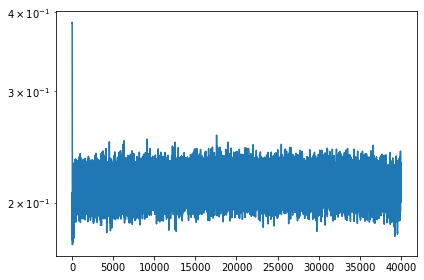

In [23]:
start_time = time.time()
pi_deepONet_relu.train(max_iter=40000, batch_size=y_train.shape[0])
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(pi_deepONet_relu, 0, 40000)

In [22]:
def get_burgers(t, X, T, Exact, random_y, uu1, net):
    xx = np.hstack((X[t:t+1, :].T, T[t:t+1, :].T))
    uu = Exact[t:t+1, :].T
    idx = np.random.choice(xx.shape[0], random_y, replace=False)
    y = xx[idx]
    y_test = uu[idx]
    x_test = np.hstack([np.tile(uu1.reshape(1, -1), (random_y, 1)), y])
    y_pred = net.predict(x_test)
    # return np.sqrt(np.sum(np.square(y_pred - y_test)))
    return np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)

In [24]:
get_burgers(90, X, T, Exact, random_y, ubci, pi_deepONet_relu)

0.6730317113002456

In [19]:
s = 0
for i in range(100):
    s += get_burgers(i, X, T, Exact, random_y, ubci, pi_deepONet_relu)
print(s / 100)

0.6807853212267022


第0次 0.397189,phy 0.000005,ope 0.397184
第100次 0.233984,phy 0.005279,ope 0.228705
第200次 0.156392,phy 0.027027,ope 0.129365
第300次 0.131195,phy 0.022578,ope 0.108617
第400次 0.077332,phy 0.010834,ope 0.066498
第500次 0.076949,phy 0.014689,ope 0.062260
第600次 0.073725,phy 0.015357,ope 0.058368
第700次 0.070964,phy 0.010532,ope 0.060431
第800次 0.142240,phy 0.025946,ope 0.116294
第900次 0.171352,phy 0.088833,ope 0.082519
第1000次 0.064596,phy 0.018854,ope 0.045742
第1100次 0.040520,phy 0.015119,ope 0.025401
第1200次 0.042294,phy 0.015144,ope 0.027150
第1300次 0.069627,phy 0.018868,ope 0.050759
第1400次 0.031429,phy 0.010555,ope 0.020874
第1500次 0.047181,phy 0.010066,ope 0.037115
第1600次 0.032679,phy 0.011332,ope 0.021347
第1700次 0.044417,phy 0.026699,ope 0.017718
第1800次 0.029510,phy 0.010651,ope 0.018858
第1900次 0.027363,phy 0.010977,ope 0.016386
第2000次 0.018484,phy 0.007462,ope 0.011022
第2100次 0.017030,phy 0.006184,ope 0.010845
第2200次 0.022076,phy 0.004849,ope 0.017228
第2300次 0.078944,phy 0.018675,ope 0.060270
第240

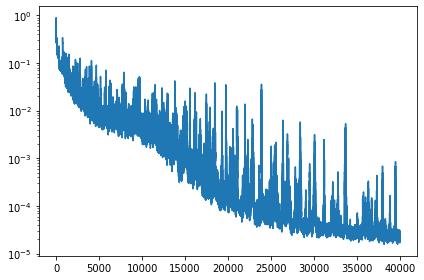

In [20]:
pi_deepONet_tanh = PI_DeepONet(x_train, y_train, branch_layers, trunk_layers, lr, tf.tanh)
start_time = time.time()
pi_deepONet_tanh.train(max_iter=40000, batch_size=y_train.shape[0])
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(pi_deepONet_tanh, 0, 40000)

In [21]:
s = 0
for i in range(100):
    s += get_burgers(i, X, T, Exact, random_y, ubci, pi_deepONet_tanh)
print(s / 100)

0.02801591261955836


第0次 0.396037,phy 0.000004,ope 0.396033
第100次 0.156785,phy 0.027697,ope 0.129088
第200次 0.101359,phy 0.018361,ope 0.082998
第300次 0.099094,phy 0.030794,ope 0.068300
第400次 0.071494,phy 0.014348,ope 0.057146
第500次 0.074524,phy 0.014429,ope 0.060096
第600次 0.072578,phy 0.016248,ope 0.056330
第700次 0.074201,phy 0.017133,ope 0.057068
第800次 0.069147,phy 0.016141,ope 0.053006
第900次 0.064298,phy 0.015747,ope 0.048552
第1000次 0.052307,phy 0.015346,ope 0.036961
第1100次 0.038784,phy 0.011091,ope 0.027693
第1200次 0.036168,phy 0.011986,ope 0.024183
第1300次 0.036968,phy 0.011658,ope 0.025311
第1400次 0.032050,phy 0.015241,ope 0.016808
第1500次 0.028725,phy 0.010927,ope 0.017798
第1600次 0.028845,phy 0.012203,ope 0.016642
第1700次 0.033314,phy 0.015612,ope 0.017702
第1800次 0.021185,phy 0.009253,ope 0.011932
第1900次 0.019021,phy 0.007088,ope 0.011933
第2000次 0.021302,phy 0.009223,ope 0.012079
第2100次 0.017975,phy 0.007638,ope 0.010337
第2200次 0.015857,phy 0.005818,ope 0.010039
第2300次 0.016811,phy 0.006599,ope 0.010213
第240

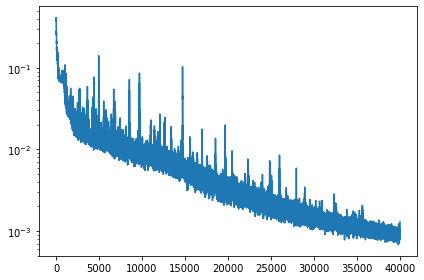

In [26]:
lr = 1e-3
branch_layers = [sensors, 20, 20, 20, 20, 20, 20, 20, 20, 1]
trunk_layers =  [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
pi_deepONet_tanh = PI_DeepONet(x_train, y_train, branch_layers, trunk_layers, lr, tf.tanh)
start_time = time.time()
pi_deepONet_tanh.train(max_iter=40000, batch_size=y_train.shape[0])
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(pi_deepONet_tanh, 0, 40000)

In [27]:
s = 0
for i in range(100):
    s += get_burgers(i, X, T, Exact, random_y, ubci, pi_deepONet_tanh)
print(s / 100)


0.052571536179241755
